Algorithm: Reading RGB image --> Getting Blob --> Loading YOLO v3 Network --> Implementing Forward Pass --> Getting Bounding Boxes --> Non-maximum Suppression --> Drawing Bounding Boxes with Labels

Result: Window with Detected Objects, Bounding Boxes and Labels

In [2]:
import numpy as np
import cv2
import time

In [4]:
# Reading input image
image_BGR = cv2.imread('traffic-sign-to-test.jpg')

# Showing image shape
print('Image shape:', image_BGR.shape) 

# Getting spatial dimension of input image
h, w = image_BGR.shape[:2]  # Slicing from tuple only first two elements

# Showing height an width of image
print('Image height={0} and width={1}'.format(h, w)) 

Image shape: (731, 1092, 3)
Image height=731 and width=1092


In [5]:
# Getting blob from input image

# blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size, mean, swapRB=True)
blob = cv2.dnn.blobFromImage(image_BGR, 1 / 255.0, (416, 416), swapRB=True, crop=False)

print('Image shape:', image_BGR.shape) 
print('Blob shape:', blob.shape) 

# Showing blob image in OpenCV window
# Slicing blob image and transposing to make channels come at the end
blob_to_show = blob[0, :, :, :].transpose(1, 2, 0)
print(blob_to_show.shape)  


Image shape: (731, 1092, 3)
Blob shape: (1, 3, 416, 416)
(416, 416, 3)


In [8]:
# Loading COCO class labels from file

with open('classes.names') as f:
    # Getting labels reading every line and putting them into the list
    labels = [line.strip() for line in f]

print('List with labels names:')
print(labels)

# Loading trained YOLO v3 Objects Detector
network = cv2.dnn.readNetFromDarknet('yolov4-tiny_test.cfg', 'yolov4-tiny_train_8000.weights')

# Getting list with names of all layers from YOLO v3 network
layers_names_all = network.getLayerNames()

print()
print(layers_names_all)

# Getting only output layers' names that we need from YOLO v3 algorithm with function that returns indexes of layers with unconnected outputs
layers_names_output = [layers_names_all[i - 1] for i in network.getUnconnectedOutLayers()]

print()
print(layers_names_output)  # ['yolo_82', 'yolo_94', 'yolo_106']

# Setting minimum probability to eliminate weak predictions
probability_minimum = 0.5

# Setting threshold for filtering weak bounding boxes with non-maximum suppression
threshold = 0.3

# Generating colours for representing every detected object with function randint(low, high=None, size=None, dtype='l')
colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

print()
print(type(colours))  
print(colours.shape) 
print(colours[0]) 

List with labels names:
['prohibitory', 'danger', 'mandatory', 'other']

('conv_0', 'bn_0', 'leaky_1', 'conv_1', 'bn_1', 'leaky_2', 'conv_2', 'bn_2', 'leaky_3', 'slice_3', 'conv_4', 'bn_4', 'leaky_5', 'conv_5', 'bn_5', 'leaky_6', 'concat_6', 'conv_7', 'bn_7', 'leaky_8', 'concat_8', 'pool_9', 'conv_10', 'bn_10', 'leaky_11', 'slice_11', 'conv_12', 'bn_12', 'leaky_13', 'conv_13', 'bn_13', 'leaky_14', 'concat_14', 'conv_15', 'bn_15', 'leaky_16', 'concat_16', 'pool_17', 'conv_18', 'bn_18', 'leaky_19', 'slice_19', 'conv_20', 'bn_20', 'leaky_21', 'conv_21', 'bn_21', 'leaky_22', 'concat_22', 'conv_23', 'bn_23', 'leaky_24', 'concat_24', 'pool_25', 'conv_26', 'bn_26', 'leaky_27', 'conv_27', 'bn_27', 'leaky_28', 'conv_28', 'bn_28', 'leaky_29', 'conv_29', 'permute_30', 'yolo_30', 'identity_31', 'conv_32', 'bn_32', 'leaky_33', 'upsample_33', 'concat_34', 'conv_35', 'bn_35', 'leaky_36', 'conv_36', 'permute_37', 'yolo_37')

['yolo_30', 'yolo_37']

<class 'numpy.ndarray'>
(4, 3)
[163 199  39]


In [9]:
#Implementing Forward pass

# Implementing forward pass with our blob and only through output layers
# Calculating at the same time, needed time for forward pass
network.setInput(blob)  # setting blob as input to the network
start = time.time()
output_from_network = network.forward(layers_names_output)
end = time.time()

# Showing spent time for forward pass
print('Objects Detection took {:.5f} seconds'.format(end - start))

Objects Detection took 0.13868 seconds


In [16]:
#Getting bounding boxes

# Preparing lists for detected bounding boxes,
# obtained confidences and class's number
bounding_boxes = []
confidences = []
class_numbers = []


# Going through all output layers after feed forward pass
for result in output_from_network:
    # Going through all detections from current output layer
    for detected_objects in result:
        # Getting 80 classes' probabilities for current detected object
        scores = detected_objects[5:]
        # Getting index of the class with the maximum value of probability
        class_current = np.argmax(scores)
        # Getting value of probability for defined class
        confidence_current = scores[class_current]

        # Every 'detected_objects' numpy array has first 4 numbers with
        # bounding box coordinates and rest 80 with probabilities for every class
        # print(detected_objects.shape)  # (85,)

        # Eliminating weak predictions with minimum probability
        if confidence_current > probability_minimum:
            # Scaling bounding box coordinates to the initial image size
            # YOLO data format keeps coordinates for center of bounding box
            # and its current width and height
            # That is why we can just multiply them elementwise
            # to the width and height
            # of the original image and in this way get coordinates for center
            # of bounding box, its width and height for original image
            box_current = detected_objects[0:4] * np.array([w, h, w, h])

            # Now, from YOLO data format, we can get top left corner coordinates
            # that are x_min and y_min
            x_center, y_center, box_width, box_height = box_current
            x_min = int(x_center - (box_width / 2))
            y_min = int(y_center - (box_height / 2))

            # Adding results into prepared lists
            bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
            confidences.append(float(confidence_current))
            class_numbers.append(class_current)
            
# Non-maximum suppression

# Implementing non-maximum suppression of given bounding boxes with this technique we exclude some of bounding boxes if their
# corresponding confidences are low or there is another bounding box for this region with higher confidence

# It is needed to make sure that data type of the boxes is 'int' and data type of the confidences is 'float'
# https://github.com/opencv/opencv/issues/12789
results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)
print(results)

[1]


In [15]:
#Drawing bounding boxes and labels

# Defining counter for detected objects
counter = 1

# Checking if there is at least one detected object after non-maximum suppression
if len(results) > 0:
    # Going through indexes of results
    for i in results.flatten():
        # Showing labels of the detected objects
        print('Object {0}: {1}'.format(counter, labels[int(class_numbers[i])]))

        # Incrementing counter
        counter += 1

        # Getting current bounding box coordinates,
        # its width and height
        x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
        box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]

        # Preparing colour for current bounding box
        # and converting from numpy array to list
        colour_box_current = colours[class_numbers[i]].tolist()

        # # # Check point
        # print(type(colour_box_current))  # <class 'list'>
        # print(colour_box_current)  # [172 , 10, 127]

        # Drawing bounding box on the original image
        cv2.rectangle(image_BGR, (x_min, y_min),
                      (x_min + box_width, y_min + box_height),
                      colour_box_current, 2)

        # Preparing text with label and confidence for current bounding box
        text_box_current = '{}: {:.4f}'.format(labels[int(class_numbers[i])],
                                               confidences[i])

        # Putting text with label and confidence on the original image
        cv2.putText(image_BGR, text_box_current, (x_min, y_min - 5),
                    cv2.FONT_HERSHEY_COMPLEX, 0.7, colour_box_current, 2)


# Comparing how many objects where before non-maximum suppression and left after
print()
print('Total objects been detected:', len(bounding_boxes))
print('Number of objects left after non-maximum suppression:', counter - 1)

cv2.imwrite('Detections.png', image_BGR)


Object 1: other

Total objects been detected: 2
Number of objects left after non-maximum suppression: 1


True

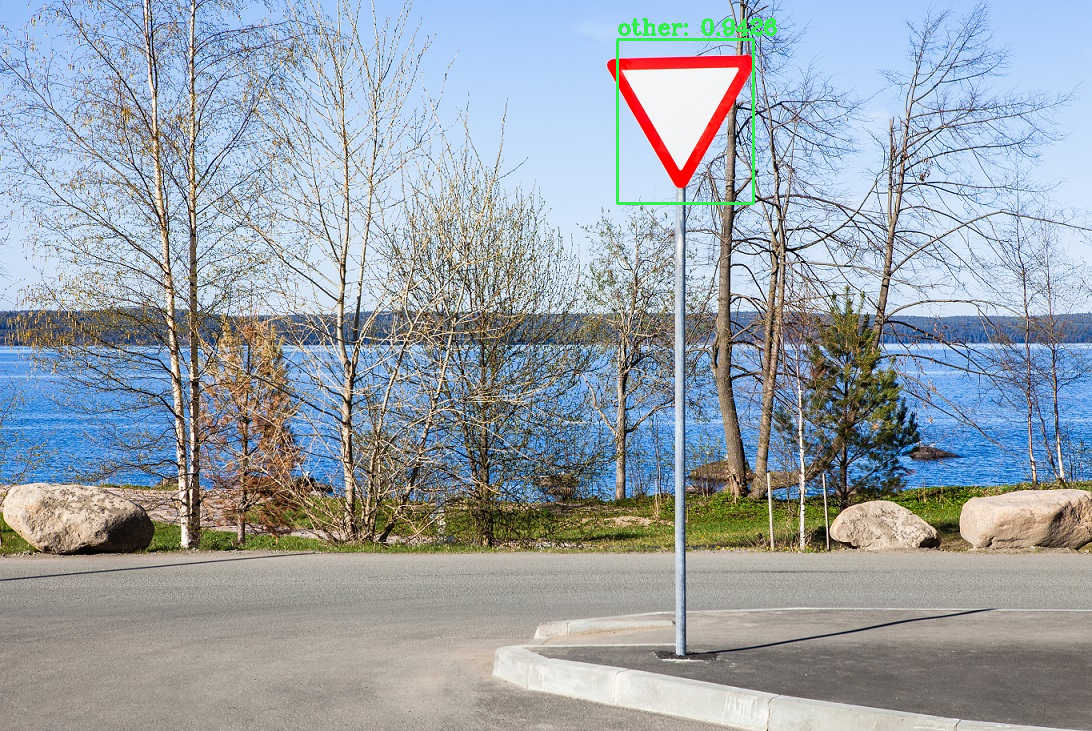